<a href="https://colab.research.google.com/github/evmpython/precipitacao_CHIRPS/blob/main/06_anomalia_de_precipitacao_CHIRPS_via_OPENDAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **ANOMALIA MENSAL DE PRECIPITAÇÃO DO CHIRPS**
---


- CHIRPS `MENSAL`
1. Site: https://catalog.data.gov/dataset/chirps-version-2-0-precipitation-global-0-05a-monthly-1981-present
2. url dos dados: https://coastwatch.pfeg.noaa.gov/erddap/griddap/chirps20GlobalMonthlyP05
3. base de dados completa: https://coastwatch.pfeg.noaa.gov/erddap/index.html
---


- Código realizado por: Enrique V. Mattos -- 20/04/2024 - enrique@unifei.edu.br


---



# **1° Passo:** Instalando as bibliotecas

In [1]:
# Instalando matplotlib, proplot e numpy
!pip install -q matplotlib==3.4.3
!pip install -q proplot==0.9.7
!pip install -q numpy==1.24.3

# Instalando salem
!pip install -q salem==0.3.9

# Instalando Xarray e suas dependências: https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
!pip install -q xarray dask netCDF4 bottleneck

# Instalando rasterio, pyproj e geopandas
!pip install -q rasterio pyproj geopandas

# Instalando cartopy
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy

Found existing installation: shapely 2.0.4
Uninstalling shapely-2.0.4:
  Successfully uninstalled shapely-2.0.4


- Chegando aqui, será necessário fazer a `Reinicialização do Ambiente de Execução`. Para isto, você deverá acessar `Ambiente de execução`, localizado na barra de ferramentas e clicar em `Reiniciar Sessão`. Como indicado na imagem abaixo.

- Em seguida você deverá rodar novamente a célula anterior de instalações, de forma que as bibliotecas sejam instaladas novamente.

- Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab. Então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

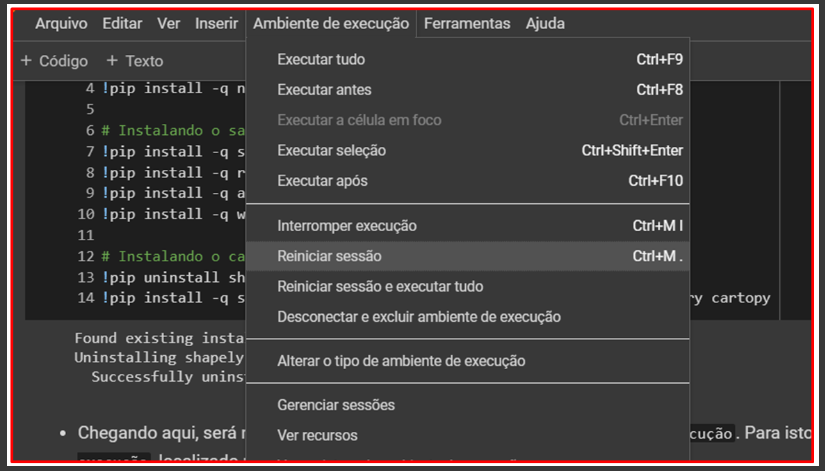

# **2° Passo:** Importando bibliotecas

In [1]:
import xarray as xr
import time
import proplot as pplt
import salem
import matplotlib
import cartopy.io.shapereader as shpreader
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# **PARTE 1)**:  LEITURA DOS DADOS E PROCESSAMENTO

##Define `ano` e `mês`

In [5]:
ano, mes = '2022', '05'
ano, mes = '2022', '12'

##Leitura dos dados

In [2]:
%%time

# leitura do shapefile do Brasil
shapefile_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')

# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# nome do mês
nome_mes =  ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

# carrega os dados do CHIRPS
chirps = xr.open_dataset('https://coastwatch.pfeg.noaa.gov/erddap/griddap/chirps20GlobalMonthlyP05')\
           .sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

# mostra os dados
chirps

CPU times: user 384 ms, sys: 46.7 ms, total: 430 ms
Wall time: 3 s


<xarray.Dataset>
Dimensions:    (time: 519, latitude: 840, longitude: 840)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2024-03-01
  * latitude   (latitude) float32 -34.97 -34.92 -34.88 ... 6.875 6.925 6.975
  * longitude  (longitude) float32 -74.98 -74.93 -74.88 ... -33.12 -33.07 -33.03
Data variables:
    precip     (time, latitude, longitude) float32 ...
Attributes: (12/32)
    _NCProperties:             version=2,netcdf=4.7.1,hdf5=1.10.5
    acknowledgements:          The Climate Hazards Group InfraRed Precipitati...
    cdm_data_type:             Grid
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             pete@geog.ucsb.edu
    creator_name:              Pete Peterson
    ...                        ...
    summary:                   This dataset has monthly averages of the Clima...
    time_coverage_end:         2024-03-01T00:00:00Z
    time_coverage_start:       1981-01-01T00:00:00Z
    title:                     CHIRPS Version 2.0, Precipitation, Global, 0.0...
    version:                   2.0
    Westernmost_Easting:       -179.975

##Calcula anomalia
- 7 min para calcular anomalia

In [6]:
%%time

# calculando a CLIMATOLOGIA
climatologia = chirps.sel(time=slice('1990-01-01','2020-12-31')).groupby("time.month").mean("time")

# calculando a ANOMALIA
anomalia = chirps.sel(time=slice(f'{ano}-{mes}-01',f'{ano}-{mes}-01')).groupby("time.month") - climatologia

# recorta o dado para região
anomalia = anomalia.salem.roi(shape=shapefile_brasil)

# mostra os dados
anomalia

CPU times: user 27.2 s, sys: 5.87 s, total: 33.1 s
Wall time: 7min 17s


<xarray.Dataset>
Dimensions:    (time: 1, latitude: 840, longitude: 840)
Coordinates:
  * time       (time) datetime64[ns] 2022-12-01
  * latitude   (latitude) float32 -34.97 -34.92 -34.88 ... 6.875 6.925 6.975
  * longitude  (longitude) float32 -74.98 -74.93 -74.88 ... -33.12 -33.07 -33.03
    month      (time) int64 12
Data variables:
    precip     (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

# **PARTE 2)**:  MAPA DE `ANOMALIA` PARA UM DETERMINADO MÊS

CPU times: user 7.1 s, sys: 897 ms, total: 8 s
Wall time: 9.44 s


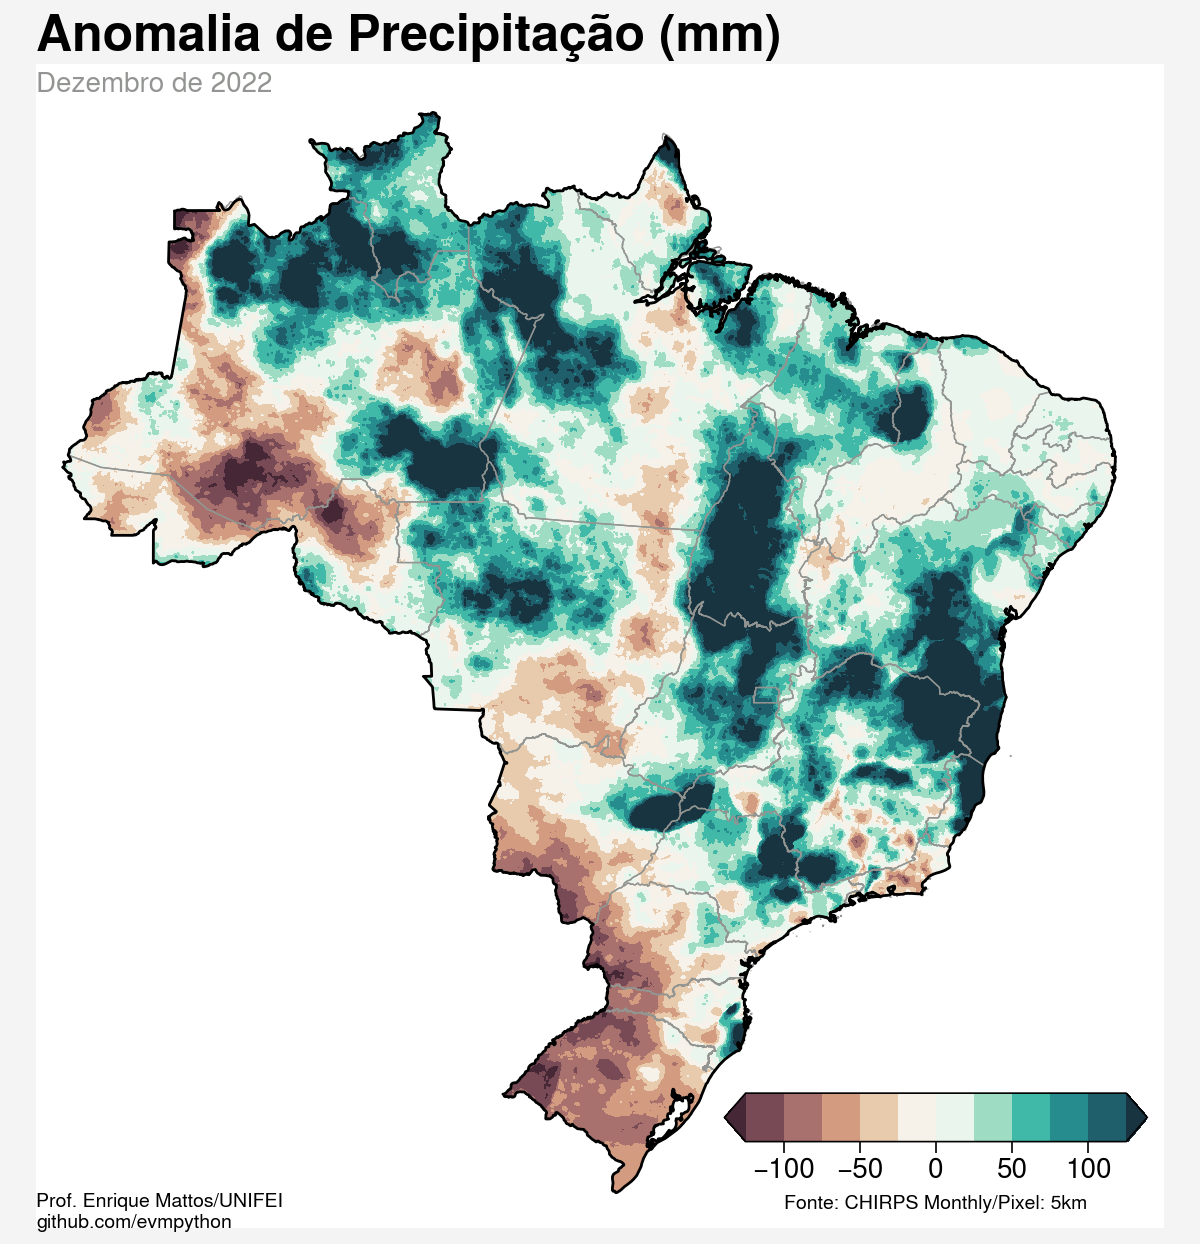

In [10]:
%%time

#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          title=f'Anomalia de Precipitação (mm)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black',
          small='20px', large='25px',
          linewidth=0, grid=False)

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'{nome_mes[int(mes)-1]} de {ano}', color='grey', fontsize=10)

# plota mapa
# configuração da barra de cores: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
map1 = ax.contourf(anomalia['longitude'],
                   anomalia['latitude'],
                   anomalia['precip'][0,:,:],
                   extend='both',
                   cmap='DryWet',
                   vmin=-125, vmax=125,
                   levels=pplt.arange(-125, 125, 25),
                   colorbar='best',
                   colorbar_kw={'label': 'Fonte: CHIRPS Monthly/Pixel: 5km',
                                'length': 18,
                                'frameon': False,
                                'ticklabelsize': 10,
                                'labelsize': 7,
                                'width': 2,
                                'ticks': 50})

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax)

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax)

# informação na figura
ax.annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

# salva figura
fig.save(f'Fig_1_CHIRPS_precipitacao_anomalia_{ano}_{mes}.png', dpi=300)

# **PARTE 3)**:  MAPA DE `PRECIPITAÇÃO` E `ANOMALIA` PARA UM DETERMINADO MÊS

CPU times: user 16.5 s, sys: 1.86 s, total: 18.3 s
Wall time: 19.5 s


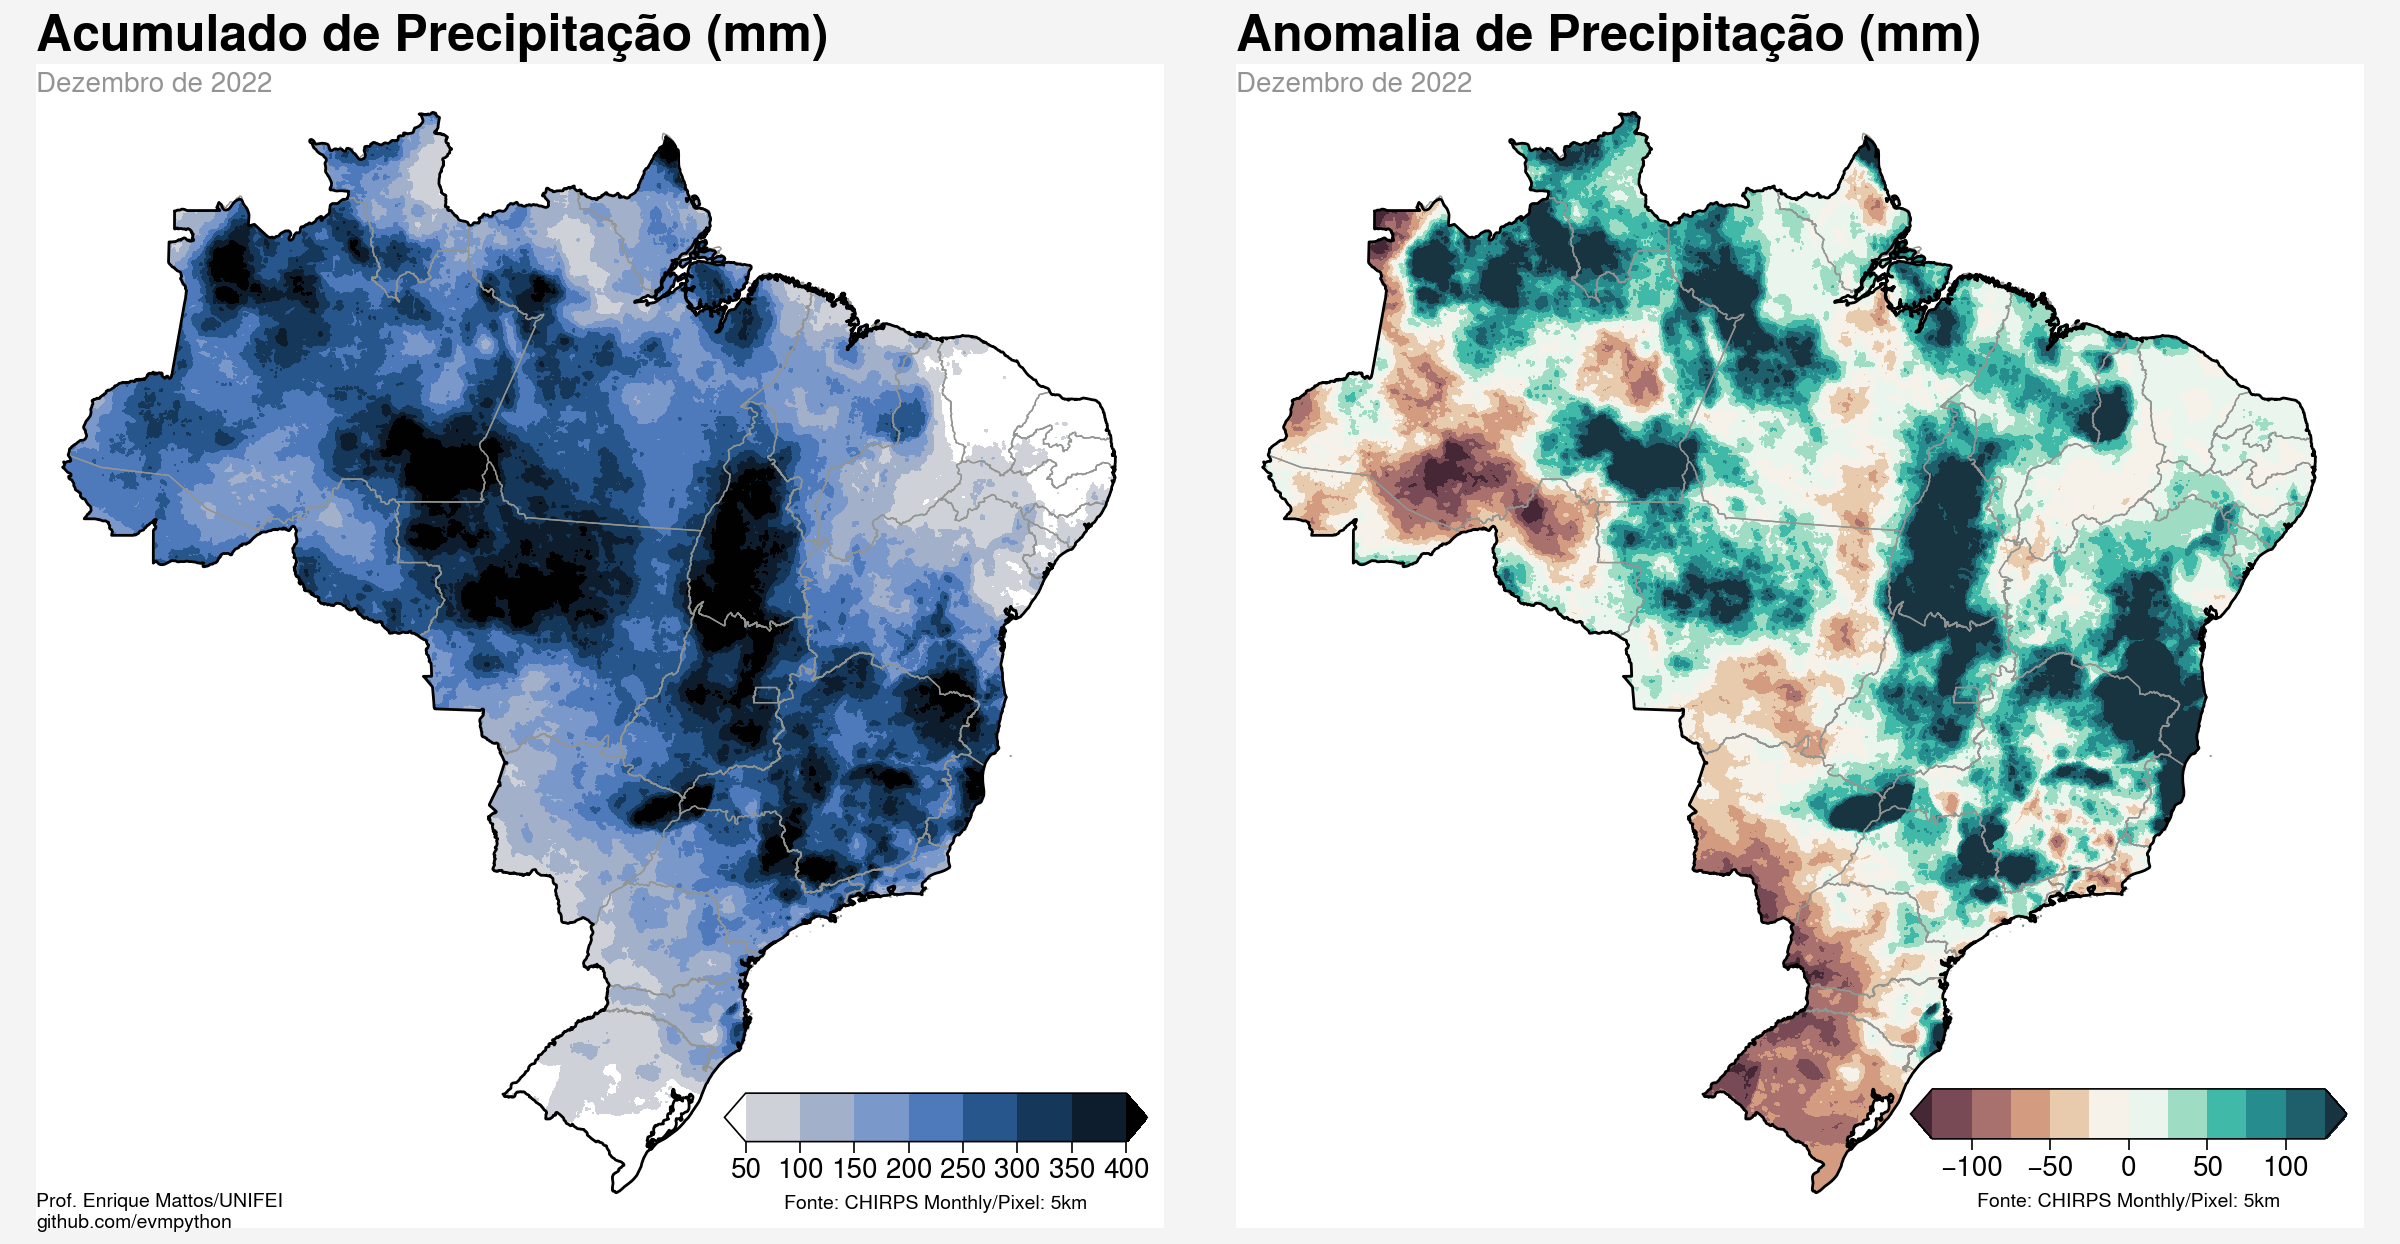

In [14]:
%%time

# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, ncols=2, nrows=1, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False)

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'{nome_mes[int(mes)-1]} de {ano}', color='grey', fontsize=10)

#--------------------------------------------------------------#
#                            FIG-1
#--------------------------------------------------------------#
# plota mapa
map1 = ax[0].contourf(chirps['longitude'],
                      chirps['latitude'],
                      chirps['precip'].loc[f'{ano}-{mes}-01'].salem.roi(shape=shapefile_brasil),
                      cmap='oslo_r',
                      vmin=50, vmax=400,
                      levels=pplt.arange(50, 400, 50),
                      extend='both',
                      colorbar='best',
                      colorbar_kw={'label': 'Fonte: CHIRPS Monthly/Pixel: 5km',
                                   'length': 18,
                                   'frameon': False,
                                   'ticklabelsize': 10,
                                   'labelsize': 7,
                                   'width': 2,
                                   'ticks': 50})

# título da figura
ax[0].format(title=f'Acumulado de Precipitação (mm)',
             titleloc='l',
             titleweight='bold',
             titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[0])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

#--------------------------------------------------------------#
#                            FIG-2
#--------------------------------------------------------------#
ax[1].contourf(anomalia['longitude'],
               anomalia['latitude'],
               anomalia['precip'][0,:,:],
               cmap='DryWet',
               vmin=-125, vmax=125,
               levels=pplt.arange(-125, 125, 25),
               extend='both',
               colorbar='best',
               colorbar_kw={'label': 'Fonte: CHIRPS Monthly/Pixel: 5km',
                            'length': 18,
                            'frameon': False,
                            'ticklabelsize': 10,
                            'labelsize': 7,
                            'width': 2,
                            'ticks': 50})

# título da figura
ax[1].format(title=f'Anomalia de Precipitação (mm)',
             titleloc='l',
             titleweight='bold',
             titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[1])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# salva figura
fig.save(f'Fig_2_CHIRPS_precipitacao_acumulada_e_anomalia_{ano}_{mes}.png', dpi=300)

# **PARTE 4)**:  MAPA DE `ANOMALIA` PARA DOIS MESES DIFERENTES

In [ ]:
%%time
#========================================================================#
#                         LEITURA DOS DADOS
#========================================================================#
# nome do mês
nome_mes =  ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# carrega os dados do CHIRPS
chirps = xr.open_dataset('https://coastwatch.pfeg.noaa.gov/erddap/griddap/chirps20GlobalMonthlyP05')\
           .sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

#========================================================================#
#                         CALCULA ANOMALIA
#========================================================================#
# leitura do shapefile do Brasil
shapefile_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')

# calculando a CLIMATOLOGIA
climatologia = chirps.sel(time=slice('1990-01-01','2020-12-31')).groupby("time.month").mean("time")

# calculando a ANOMALIA
ano1, mes1 = '2022', '12'
ano2, mes2 = '2023', '12'

anomalia1 = chirps.sel(time=slice(f'{ano1}-{mes1}',f'{ano1}-{mes1}')).groupby("time.month") - climatologia
anomalia2 = chirps.sel(time=slice(f'{ano2}-{mes2}',f'{ano2}-{mes2}')).groupby("time.month") - climatologia

# recorta o dado para região
anomalia1 = anomalia1.salem.roi(shape=shapefile_brasil)
anomalia2 = anomalia2.salem.roi(shape=shapefile_brasil)

In [ ]:
%%time

# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, ncols=2, nrows=1, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False,
          suptitle=f'Anomalia de Temperatura ($\degree$C)')

#--------------------------------------------------------------#
#                            FIG-1
#--------------------------------------------------------------#
# plota mapa
map1 = ax[0].contourf(anomalia1['longitude'],
                      anomalia1['latitude'],
                      anomalia1['precip'][0,:,:],
                      cmap='DryWet',
                      vmin=-125, vmax=125,
                      levels=pplt.arange(-125, 125, 25),
                      extend='both',
                      colorbar='best',
                      colorbar_kw={'label': 'Fonte: CHIRPS Monthly/Pixel: 5km',
                                   'length': 18,
                                   'frameon': False,
                                   'ticklabelsize': 10,
                                   'labelsize': 7,
                                   'width': 2,
                                   'ticks': 50})

# título da figura
ax[0].format(title=f'{nome_mes[int(mes1)-1]} de {ano1}',
             titleloc='c',
             titleweight='bold',
             titlecolor='grey')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[0])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

#--------------------------------------------------------------#
#                            FIG-2
#--------------------------------------------------------------#
ax[1].contourf(anomalia2['longitude'],
               anomalia2['latitude'],
               anomalia2['precip'][0,:,:],
               cmap='DryWet',
               vmin=-125, vmax=125,
               levels=pplt.arange(-125, 125, 25),
               extend='both',
               colorbar='best',
               colorbar_kw={'label': 'Fonte: CHIRPS Monthly/Pixel: 5km',
                            'length': 18,
                            'frameon': False,
                            'ticklabelsize': 10,
                            'labelsize': 7,
                            'width': 2,
                            'ticks': 50})

# título da figura
ax[1].format(title=f'{nome_mes[int(mes2)-1]} de {ano2}',
             titleloc='c',
             titleweight='bold',
             titlecolor='grey')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[1])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# salva figura
fig.save(f'Fig_3_CHIRPS_precipitacao_anomalia_{ano1}{mes1}_{ano2}{mes2}.png', dpi=300)